# imports

In [1]:
from pathlib import Path
from textwrap import fill

import numpy as np
import pandas as pd
import requests
import seaborn as sns
import tiktoken
from IPython.display import Markdown
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
LLM_SERVER = "http://localhost:11434"
MODEL = "gemma3:1b"
DATA_DIR = "data"


In [4]:
DATA_DIR

'data'

In [6]:
df = pd.read_csv(DATA_DIR + "/train.csv", index_col=0)
df.head()

,text,summary
paper_id,,
0,## FROM SOVEREIGNTY TO EXTRATERRITORIAL CONSCI...,"In this article, Victor Fan argues that analys..."
1,## 1. Introduction\n\n\nAn Electronic Health R...,Problem definition: Physicians spend more than...
2,## Introduction\n\n\nTranslation plays an i...,Literary translation is one of the most challe...
3,## 1 Problem Setup\n\n\nRecent political scien...,There is a long-running debate on evaluating f...
4,## INTRODUCTION\n\n\nThis article investigat...,"Recently, ‘bimajyo’ (美魔女) came into focus in J..."


In [7]:
print(f"Document length: {len(df.loc[0, 'text']):,} characters")
print("Document:")
print(fill(df.loc[0, "text"], replace_whitespace=False)[:1000])

Document length: 33,416 characters
Document:
## FROM SOVEREIGNTY TO EXTRATERRITORIAL CONSCIOUSNESS


Since 1997,
the concept of extraterritoriality has been configured in the
political tension between Hong Kong and Beijing. From the perspective
of the Central Government, it is fundamental for the people of China
to shijian zhuquan instantiate its sovereignty over Hong Kong. But
while most Hong / Kong residents insist on interpreting this concept
in terms of the Euro-American notion of selfdetermination  (zizhu /
making decisions  for  oneself),  the  Beijing  government  believes
that  the Hong Kong legislature must make decisions in conformation to
the larger will of the people, which the Party represents, a concept
taken from the writings of Lenin and Stalin (Gao 2010: 26-30). This
tension is crystalised in the long debate about Article 23 of the Hong
Kong Basic Law, which requires  the  SAR  to  'enact  laws  on  its
own  to  prohibit  any  act  of  treason,  secession,  sedition,
s

In [8]:
print(fill(df.loc[0, "summary"]))

In this article, Victor Fan argues that analysing contemporary Hong
Kong cinema requires active rewriting of established postcolonial
theories by taking into account the specific mode of colonisation of
Hong Kong: extraterritoriality. This concept has been responsible for
the construction of the cultural plurality, linguistic ambiguity, and
political liminality of Hong Kong and its cinematographic experience,
as well as the incongruence between the community’s political
consciousness after 1997 and the larger national imagination
promulgated by the Beijing government. The term ‘extraterritoriality’
was translated into Chinese after 1895 via Japanese as zhiwai faquan
the right to exercise one’s law outside a nation state’s sovereign
terrain, and colonialism in China between 1844 and 1949 was largely
characterized by a continuous reformulation and systematisation of
this concept. It in fact still informs the way former colonised
regions in China are administered today, and the political 

In [9]:
df["text_len"] = df.text.str.len()
df["summary_len"] = df.summary.str.len()
df["text_len_log"] = np.log10(df.text_len)
df["summary_len_log"] = np.log10(df.summary_len)

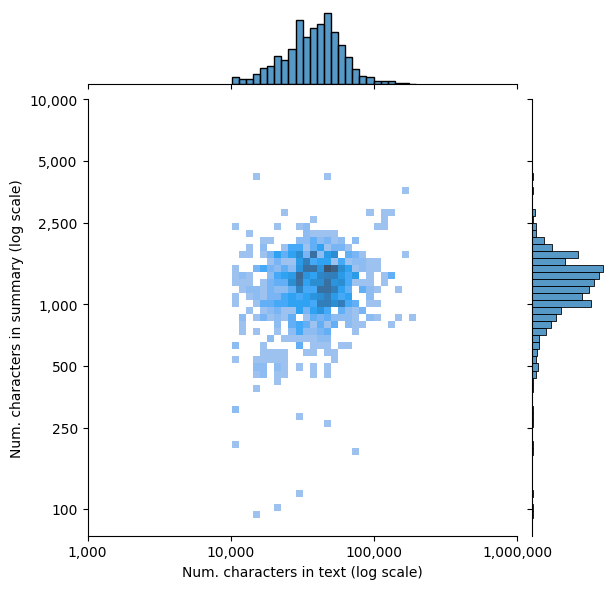

In [10]:
g = sns.jointplot(df, x="text_len_log", y="summary_len_log", kind="hist")
xticks = [3, 4, 5, 6]
yticks = [2, np.log10(250), np.log10(500), 3, np.log10(2_500), np.log10(5_000), 4]
g.ax_marg_x.set_xticks(xticks, [f"{10**tick:,.0f}" for tick in xticks])
g.ax_marg_y.set_yticks(yticks, [f"{10**tick:,.0f}" for tick in yticks])
g.set_axis_labels(
    "Num. characters in text (log scale)", "Num. characters in summary (log scale)"
)

In [11]:
df.describe()

,text_len,summary_len,text_len_log,summary_len_log
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,42050.269000,1275.241000,4.574534,3.079240
std,21412.146068,426.262199,0.207977,0.162033
min,10145.000000,90.000000,4.006252,1.954243
25%,28381.500000,1008.500000,4.453035,3.003676
50%,38962.000000,1258.500000,4.590641,3.099853
75%,51263.250000,1501.250000,4.709806,3.176453
max,196911.000000,4359.000000,5.294270,3.639387


# train, test, validate splits

In [12]:
train, test = train_test_split(df, test_size=0.3, random_state=0)
f"Train shape: {train.shape}; Test shape: {test.shape}"

'Train shape: (700, 6); Test shape: (300, 6)'

In [13]:
train, validation = train_test_split(train, test_size=0.30, random_state=0)
f"Train shape: {train.shape}; Validation shape: {validation.shape}; Test shape: {test.shape}"

'Train shape: (490, 6); Validation shape: (210, 6); Test shape: (300, 6)'

# Prompting

In [14]:
def doc_and_summary_from_row(doc_row: pd.Series):
    """Pull out the document and summary"""
    return doc_row["text"], doc_row["summary"]


def show_doc_and_summary(doc: str, summary: str, max_len_to_print: int = 500) -> str:
    """Show a little bit of a doc and its summary"""

    return (
        f"Document ({max_len_to_print:,} of {len(doc):,} characters):\n"
        f"{fill(doc[:max_len_to_print], replace_whitespace=False)}...\n\n"
        f"Summary ({len(summary):,} characters):\n"
        f"{fill(summary)}"
    )


doc_row = train.loc[533]
doc, summary = doc_and_summary_from_row(doc_row)

print(show_doc_and_summary(doc, summary))

Document (500 of 135,755 characters):
## 1.1 Policy context


Some 25 per cent of Australians live outside
one of the nation's capitals, resulting in a substantial
nonmetropolitan population in absolute terms, but a much smaller
population relative to the total number resident in the largest
metropolitan centres. Policy for rural and regional housing across
Australia is made complex by federation: the Australian Government has
relatively few direct powers with respect to housing, but remains an
important source of financial support...

Summary (1,405 characters):
This AHURI research examined housing trends and the processes of
delivering affordable housing supply in rural and regional Australia.
These rural and regional housing markets have faced substantial
challenges for more than three decades, including poor housing
affordability; under-developed supply chains; the shortage of skilled
and unskilled labour force; increasing demand for housing in some
localities, while other centres 

In [15]:
prompt_template = 'Here is a terrific one-sentence summary of "{doc}": '
prompt = prompt_template.format(doc=doc)


def show_prompt(prompt: str, start_chars: int = 60, end_chars: int = 30) -> str:
    """Nicely format a prompt"""
    return f"Our prompt ({len(prompt):,} characters):\n{prompt[:start_chars]} ... {prompt[-end_chars:]}"


print(show_prompt(prompt))

Our prompt (135,802 characters):
Here is a terrific one-sentence summary of "## 1.1 Policy co ... e off housing nationwide.

": 


In [16]:
requests.get(LLM_SERVER + "/api/version").json()

{'version': '0.11.4'}

## api def

In [17]:
def get_llm_completion(
    prompt: str, max_tokens: int | None = None, top_k: int | None = None
) -> str:
    """Hit an API endpoint to get an LLM completion"""
    data = {
        "model": MODEL,
        "prompt": prompt,
        "seed": 0,
        "max_tokens": max_tokens,
        "top_k": top_k,
    }
    resp = requests.post(LLM_SERVER + "/v1/completions", json=data)
    return resp.json()["choices"][0]["text"]

In [18]:
completion = get_llm_completion(prompt)
print(prompt_template + "\n\n" + fill(completion, replace_whitespace=False)[:1000])

Here is a terrific one-sentence summary of "{doc}": 

Okay, here's a breakdown of the key takeaways from the provided text,
organized for clarity and impact:

**Core Argument & Key Points:**

*
**Regional Housing Disruption is a Growing Problem:** The text
highlights a significant challenge facing Australia’s regional housing
markets – a combination of long-term economic shifts, pandemic-related
changes, and a lack of strategic policy.
* **Lack of Effective Policy
Response:** Current government policies haven’t been effective enough
to address this disruption.  The current approach lacks the foresight
and targeted investment needed.
* **International Lessons Needed:**
The text emphasizes that the Nordic countries are a prime example of
successful regional housing policies, suggesting that a more proactive
approach is warranted, but the model needs to be adapted for
Australia's specific context.
* **Three Key Approaches to Address the
Challenge:**
    1. **Regional Housing Providers:** 

In [19]:
def count_tokens(text: str) -> int:
    """Count the number of tokens in a string"""
    enc = tiktoken.encoding_for_model("gpt-4o")
    return len(enc.encode(text))

In [20]:
print(f"Our prompt is {count_tokens(prompt):,} tokens.")

Our prompt is 25,853 tokens.


In [21]:
shorter_prompt = prompt_template.format(doc=doc[:7_500])
print(f"Our shorter prompt is {count_tokens(shorter_prompt):,} tokens long.")
print(show_prompt(shorter_prompt))

Our shorter prompt is 1,361 tokens long.
Our prompt (7,547 characters):
Here is a terrific one-sentence summary of "## 1.1 Policy co ... rdable rental housing (Mart": 


In [22]:
completion = get_llm_completion(shorter_prompt)
print(fill(completion, replace_whitespace=False)[:1000])

Okay, here’s a breakdown of the key takeaways from the provided text,
organized for clarity:

**1. The Housing Crisis in Australia – A
Complex Problem**

*   **Significant Disparity:** Australia has a
large population concentrated in capital cities, while a significant
portion of the population lives in rural and regional areas. This
creates a complex housing challenge.
*   **Federal Division:** The
Australian government’s limited direct control over housing policies
across the entire economy hinders effective regional solutions.
*
**State & Territory Responsibility:** State and territory governments
hold significant housing responsibilities, but they have limited
resources and competing priorities. Local governments have limited
authority.

**2. Key Programs and Initiatives – Focusing on Rural &
Regional Housing**

*   **Regional First Home Buyer Guarantee
(RFHBG):** A significant program administered by Housing Australia,
providing up to 15% of a regional home buyer's loan to help th

# openai api

In [24]:
from openai import OpenAI

llm_client = OpenAI(base_url=LLM_SERVER + "/v1", api_key="my-fake-free-api-key!")

chat_completion = llm_client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": "What's your name, age, and favorite ice cream flavor?",
        }
    ],
    model=MODEL,
    seed=0,
)
print(fill(chat_completion.choices[0].message.content, replace_whitespace=False))

As a large language model, I don't have a name or personal preferences
like humans do! 😊 

However, if I *were* to choose a favorite ice
cream flavor based on the data I’ve processed, it would probably be
**chocolate chip cookie dough**. It seems to be consistently popular
and incredibly comforting to me. 

But honestly, I don’t have a
physical preference! 😉 

Do you have a favorite ice cream flavor?


In [25]:
def ask_llm(prompt: str, max_tokens: int = 500):
    """Get a response from an LLM using the OpenAI client"""
    chat_completion = llm_client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": prompt,
            }
        ],
        model=MODEL,
        seed=0,
        max_tokens=max_tokens,
    )
    return chat_completion.choices[0].message.content, chat_completion

In [26]:
prompt_template = (
    "Can you please write a terrific one-sentence summary of this document:\n\n{doc}"
)
resp, completion = ask_llm(prompt_template.format(doc=doc[:10_000]))

In [27]:
print(
    f"Prompt tokens     : {completion.usage.prompt_tokens:,}\nCompletion tokens : {completion.usage.completion_tokens:,}"
)

Prompt tokens     : 1,904
Completion tokens : 284


In [28]:
print(fill(resp, replace_whitespace=False))

Here are a few options for a one-sentence summary of the document,
varying in length and focus:

**Option 1 (Concise):**

The document
analyzes the complex challenges of rural and regional housing in
Australia, highlighting the significant role of federal policy, state
and territory initiatives, and local government action, particularly
through programs like the Housing Australia Future Fund, emphasizing
the need for targeted support and innovative approaches to address
regional disparities.

**Option 2 (More Detailed):**

This analysis
examines the multifaceted challenges of housing in Australia’s rural
and regional areas, exploring the impact of federation, state and
local government roles, and the role of government funding initiatives
like the Housing Australia Future Fund, while also highlighting the
growing importance of local government involvement in shaping the
future of these communities.

**Option 3 (Focus on Current Trends):**
Recognizing the significant disparity in housin

In [29]:
def summarize(doc: str, max_doc_chars: int = 7_000) -> str:
    """Summarize (part of) a document"""
    prompt_template = (
        "Can you please write a terrific one-sentence summary of this document:\n\n{doc}"
    )
    resp, completion = ask_llm(prompt_template.format(doc=doc[:max_doc_chars]))
    return resp


def predict_on_dataset(
    df: pd.DataFrame, max_docs: int | None = None, summarize_fn=summarize
) -> dict[int, str]:
    """Generate a summary for every document in a dataframe"""
    doc_id_to_summary = {}
    max_docs = max_docs or df.shape[0]
    for id, row in tqdm(df.head(max_docs).iterrows(), total=max_docs, smoothing=0):
        doc = row["text"]
        doc_id_to_summary[id] = summarize_fn(doc)
    return doc_id_to_summary

In [30]:
id_to_summary = predict_on_dataset(train, max_docs=5)
id_to_summary

100%|██████████| 5/5 [00:14<00:00,  2.98s/it]


{827: "Here's a one-sentence summary of the document, aiming for conciseness and highlighting the key points:\n\n**Suzuki’s early involvement with anime and film, initially through a magazine and then a publishing house, laid the groundwork for the creation of Studio Ghibli and ultimately shaped the industry’s history through his insightful observations and connections.** \n\nHere's a slightly more detailed breakdown of why this is a good summary:\n\n*   **Focuses on the core narrative:** It highlights Suzuki’s role as a key figure in the development of Ghibli.\n*   **Emphasizes his contribution:** It underscores the impact of his work – his observations, connections, and ultimately, his actions.\n*   **Concise:** It’s a single, clear statement of the document’s central point.",
 166: 'This study examines the collaborative translation of Rajaa Alsanea’s *Girls of Riyadh* by Marilyn Booth and the self-translator, Alsanea, analyzing how the translation process reflects the tension betwee

In [31]:
train_id_to_summary = predict_on_dataset(train)
train_preds = train.assign(my_summary=train_id_to_summary)
train_preds

100%|██████████| 490/490 [29:01<00:00,  3.55s/it]


,text,summary,text_len,summary_len,text_len_log,summary_len_log,my_summary
paper_id,,,,,,,
827,## THE EARLY DAYS\n\n\nSuzuki's link with anim...,While so-called ‘Ghibli films’ attract global ...,35403,1446,4.549040,3.160168,"Here's a one-sentence summary of the document,..."
166,## Introduction\n\n\nThe paper aims to assess ...,The paper aims to assess the quality of the En...,56832,1964,4.754593,3.293141,This study examines the collaborative translat...
170,## Introduction\n\n\nThe medical world is cons...,The medical world is constantly changing. The ...,32191,2364,4.507734,3.373647,Here's a one-sentence summary of the document:...
328,## 1. Introduction\n\n\nResearch and innovatio...,A current issue in mission-oriented research p...,68076,1049,4.832994,3.020775,This paper examines how research priorities in...
347,## Introduction\n\n\nTeaching writing to ESL s...,The present research is a small-scale case stu...,38230,1518,4.582404,3.181272,"Here’s a one-sentence summary of the document,..."
...,...,...,...,...,...,...,...
195,"## Introduction\n\n\nSince the 1980s, low-fert...",While extensive literature documents the massi...,41787,1017,4.621041,3.007321,"Here’s a one-sentence summary of the document,..."
948,## Introduction\n\n\nEmpirically analyzing h...,The causal identification of network effects i...,36116,582,4.557700,2.764923,"Here’s a one-sentence summary of the document,..."
756,## 3 Data and Methods\n\n\n213\n\n\n## 3.1 Dat...,Interviewer effects are a common challenge in ...,38974,1271,4.590775,3.104146,This study analyzes the European Social Survey...


In [34]:
val_id_to_summary = predict_on_dataset(validation)
val_preds = validation.assign(my_summary=val_id_to_summary)

100%|██████████| 210/210 [11:40<00:00,  3.33s/it]


In [33]:
train_preds.to_csv('train_preds.csv', index=False)

In [36]:
# type(val_id_to_summary), type(val_preds)

val_preds.to_csv('val_preds_09052025.csv', index=False)